In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy 
import nltk
import re
import os
import codecs
from sklearn import feature_extraction

In [2]:
ds = pd.read_csv('../dataset/wiki/opinions.csv')
print(ds.shape)
ds.columns

(17243, 8)


Index(['page_id', 'page_title', 'contributor', 'timestamp', 'topic', 'raw',
       'text', 'type'],
      dtype='object')

In [3]:
ds.type.unique()

array(['auto_ignore', 'auto_topic', 'unknown'], dtype=object)

# preprocessing

clean NaN values

In [4]:
ds.loc[ds.text.isnull(), 'text'] = ''
ds = ds[~ds.topic.isnull()]
ds = ds[~ds.type.str.startswith('auto_')]
ds = ds[ds.page_title.str.startswith('Talk') & ds.page_title.str.contains('Donald')]
ds.shape

(1696, 8)

remove stop words

In [5]:
# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')

In [6]:
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [7]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [8]:
#stemming/tokenizing
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in ds.text.values:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [9]:
#DataFrame with the stemmed vocabulary as the index and the tokenized words as data
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
vocab_frame.shape

(23881, 1)

In [10]:
def preprocess_opinion(text):
    #tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    
    #sentences = [nltk.pos_tag(sent) for sent in sentences]
    
    #remove punctuation and split into seperate words
    tokens = re.findall(r'\w+', text,flags = re.UNICODE ) 

    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token) and token not in stopwords:
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return " ".join(stems)
    

In [11]:
ds.loc[:, 'ptext'] = ds.text.apply(lambda text: preprocess_opinion(text))

In [12]:
ds.shape

(1696, 9)

In [13]:
ds.to_csv('../dataset/wiki/opinions_preprocessed.csv', index=False, header=True)

# K-means clustering

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.05, max_features=500,
                                 min_df=0.01, stop_words='english',
                                 use_idf=False, tokenizer=tokenize_and_stem)#, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(ds.text.values)

print(tfidf_matrix.shape)

CPU times: user 941 ms, sys: 8.69 ms, total: 949 ms
Wall time: 948 ms
(1696, 117)


In [37]:
terms = tfidf_vectorizer.get_feature_names()

In [38]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

In [39]:
ds.topic.nunique()

30

In [40]:
from sklearn.cluster import KMeans
from sklearn import metrics

In [41]:
clusters = range(2, 10)
km = [KMeans(n_clusters=i) for i in clusters]
scores = []
silhouette_scores = []
ch_scores = []

for i in range(len(km)):
    model = km[i].fit(tfidf_matrix)
    scores.append(model.score(tfidf_matrix))
    labels = model.labels_
    silhouette_scores.append(metrics.silhouette_score(tfidf_matrix, labels, metric='euclidean'))
    ch_scores.append(metrics.calinski_harabaz_score(tfidf_matrix.toarray(), labels))


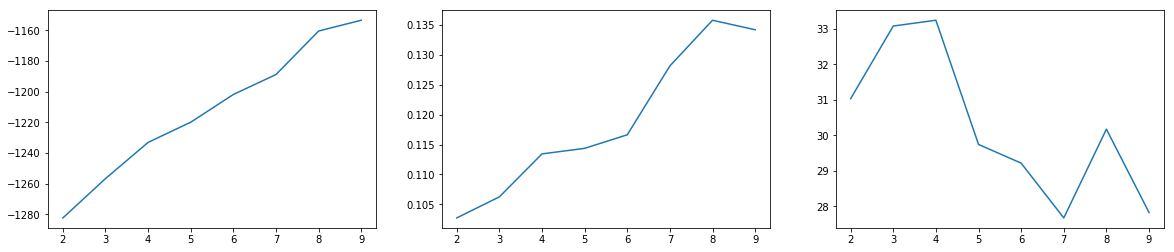

In [42]:
#scores
plt.figure(figsize=(20,4))
plt.subplot(1,3,1)
plt.plot(clusters, scores)
plt.subplot(1,3,2)
plt.plot(clusters, silhouette_scores)
plt.subplot(1,3,3)
plt.plot(clusters, ch_scores)

In [43]:
num_clusters = 8
km = KMeans(n_clusters=num_clusters)
%time km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

CPU times: user 405 ms, sys: 3.83 ms, total: 408 ms
Wall time: 408 ms


In [44]:
ds['cluster'] = clusters

In [45]:
ds['cluster'].value_counts()

4    1255
7     120
1      81
2      64
3      60
6      45
5      43
0      28
Name: cluster, dtype: int64

In [46]:
ds2 = ds.set_index(['cluster'])

In [47]:
from __future__ import print_function

print("Top terms per cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    for ind in order_centroids[i, :6]:
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    #print("Cluster %d topics:" % i, end='')
    #for title in ds2.ix[i]['topic'].unique():#.tolist():
    #    print(' %s,' % title, end='')
    #print()
    print()

Top terms per cluster:

Cluster 0 words: b'link', b'section', b'country', b'think', b'use', b'know',
Cluster 1 words: b'business', b'support', b'russian', b'deal', b'just', b'government',
Cluster 2 words: b'consensus', b'discussion', b'version', b'rfc', b'change', b'current',
Cluster 3 words: b'why', b'know', b'russian', b'including', b'word', b'come',
Cluster 4 words: b'rfc', b'just', b'section', b'think', b'russian', b'time',
Cluster 5 words: b'doe', b'because', b'clear', b'section', b'alleged', b'need',
Cluster 6 words: b'only', b'plurality', b'mention', b'including', b'wanted', b'accepted',
Cluster 7 words: b'president', b'lose', b'fifth', b'became', b'plurality', b'national',


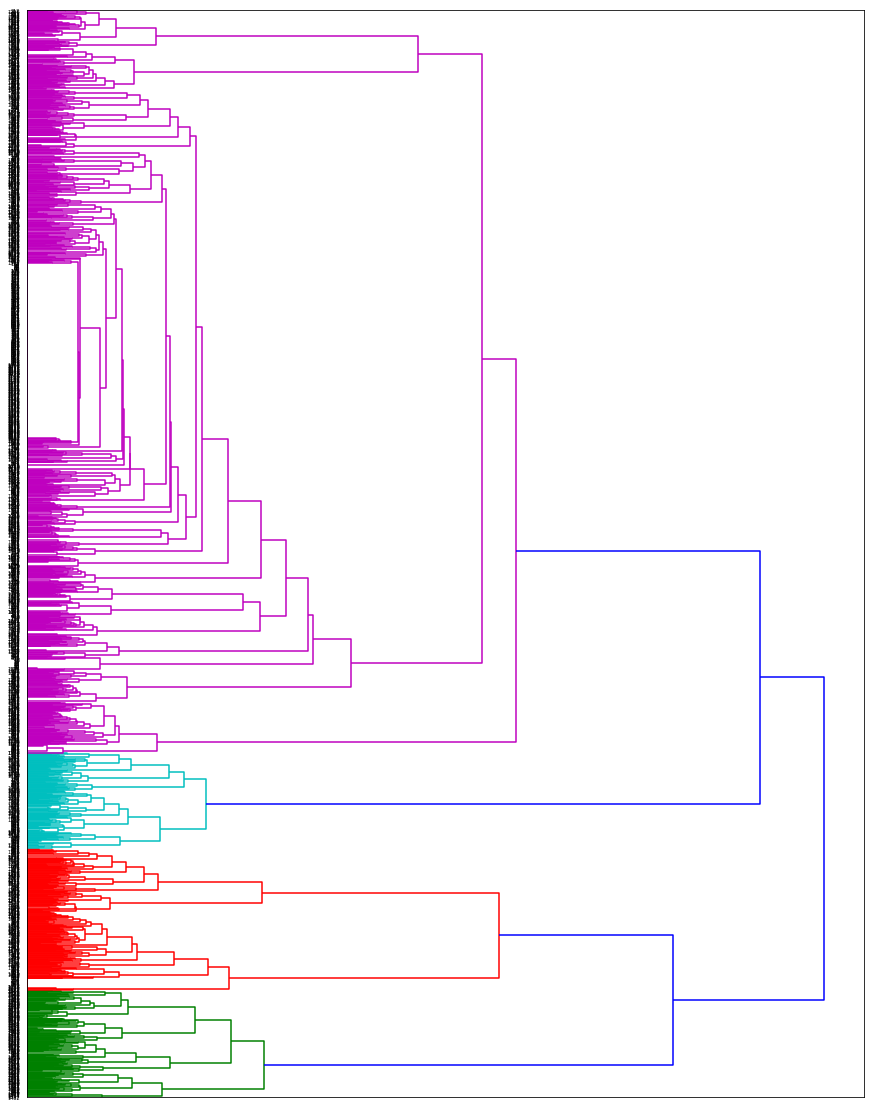

In [61]:
from scipy.cluster.hierarchy import ward, dendrogram



linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right")#, labels=ds.topic.values);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')


In [48]:
#strip any proper names from a text...unfortunately right now this is yanking the first word from a sentence too.
import string
def strip_proppers(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.islower()]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()

from gensim import corpora, models, similarities 

#remove proper names
%time preprocess = [strip_proppers(doc) for doc in ds.ptext.values]

#tokenize
%time tokenized_text = [tokenize_and_stem(text) for text in preprocess]

#remove stop words
%time texts = [[word for word in text if word not in stopwords] for text in tokenized_text]

CPU times: user 325 ms, sys: 1.44 ms, total: 327 ms
Wall time: 327 ms
CPU times: user 609 ms, sys: 5.73 ms, total: 615 ms
Wall time: 615 ms
CPU times: user 36.8 ms, sys: 604 µs, total: 37.4 ms
Wall time: 37.3 ms


In [49]:
#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=1, no_above=0.8)

#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in texts]

In [70]:
%time lda = models.LdaModel(corpus, num_topics=8, id2word=dictionary, update_every=5, chunksize=10000, passes=100)

CPU times: user 4min 35s, sys: 797 ms, total: 4min 35s
Wall time: 4min 36s


In [53]:
lda.show_topics()

[(0,
  '0.041*"trump" + 0.028*"articl" + 0.022*"donald" + 0.015*"sourc" + 0.012*"campaign" + 0.011*"elect" + 0.011*"also" + 0.010*"agr" + 0.010*"section" + 0.009*"presid"'),
 (1,
  '0.028*"rfc" + 0.022*"consensus" + 0.016*"support" + 0.015*"discuss" + 0.013*"version" + 0.012*"option" + 0.011*"suggest" + 0.010*"go" + 0.010*"oppo" + 0.008*"point"'),
 (2,
  '0.051*"vote" + 0.042*"popular" + 0.024*"lose" + 0.020*"plural" + 0.020*"presid" + 0.020*"fifth" + 0.012*"elect" + 0.012*"like" + 0.011*"edit" + 0.011*"sourc"'),
 (3,
  '0.028*"one" + 0.025*"link" + 0.018*"say" + 0.010*"realli" + 0.009*"also" + 0.008*"way" + 0.007*"politician" + 0.007*"trump" + 0.007*"get" + 0.006*"two"'),
 (4,
  '0.045*"russia" + 0.044*"tie" + 0.030*"trump" + 0.018*"russian" + 0.017*"busi" + 0.010*"govern" + 0.010*"section" + 0.009*"would" + 0.008*"propo" + 0.008*"elect"')]

In [69]:
import numpy as np
topics_matrix = lda.show_topics(formatted=False, num_words=20)
#topics_matrix = np.array(topics_matrix)

topic_words = topics_matrix[:]
for i in topic_words:
    print([str(word[0]) for word in i[1]])
    print()

['trump', 'articl', 'donald', 'sourc', 'campaign', 'elect', 'also', 'agr', 'section', 'presid', 'reliabl', 'presidenti', 'url', 'may', 'mention', 'work', 'say', 'russian', 'see', 'new']

['rfc', 'consensus', 'support', 'discuss', 'version', 'option', 'suggest', 'go', 'oppo', 'point', 'word', 'close', 'comment', 'articl', 'clear', 'phrase', 'url', 'want', 'chang', 'thank']

['vote', 'popular', 'lose', 'plural', 'presid', 'fifth', 'elect', 'like', 'edit', 'sourc', 'say', 'option', 'get', 'win', 'lost', 'first', 'major', 'without', 'think', 'reliabl']

['one', 'link', 'say', 'realli', 'also', 'way', 'politician', 'trump', 'get', 'two', 'thought', 'state', 'sentenc', 'includ', 'object', 'use', 'vote', 'think', 'might', 'exist']

['russia', 'tie', 'trump', 'russian', 'busi', 'govern', 'section', 'would', 'propo', 'elect', 'seem', 'time', 'sourc', 'peopl', 'includ', 'header', 'deal', 'say', 'think', 'chang']



In [64]:
topics_matrix = lda.show_topics(formatted=False, num_words=20)


In [65]:
topics_matrix[1]


(1,
 [('rfc', 0.028445503482475782),
  ('consensus', 0.022116224259960869),
  ('support', 0.015676766656297848),
  ('discuss', 0.014685646364510771),
  ('version', 0.013132873528372993),
  ('option', 0.012014510680980894),
  ('suggest', 0.010836783780856129),
  ('go', 0.010133869220024587),
  ('oppo', 0.0097132533836071181),
  ('point', 0.00841543670495838),
  ('word', 0.0080876879299019936),
  ('close', 0.00771033140445972),
  ('comment', 0.0074906802592556851),
  ('articl', 0.0073844646034343297),
  ('clear', 0.0073420529321380507),
  ('phrase', 0.0072738355379321088),
  ('url', 0.0070960538090636986),
  ('want', 0.0070119315396965122),
  ('chang', 0.0068766648384777475),
  ('thank', 0.0066195895596135547)])